In [130]:
from bankingSystemRL import * 
from helperFunctions import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx
import warnings 
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%pylab inline 
pylab.rcParams['figure.figsize'] = (20, 20)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [131]:
# simulation and data collection
simulationSteps = 1000
def R_tau(model_data):
    value = (model_data['Asset Matrix'][simulationSteps] +
    model_data['Liability Matrix'][simulationSteps].T.sum(axis = 1, keepdims = True) - model_data['Liability Matrix'][simulationSteps].sum(axis = 1, keepdims=True)) - (model_data['Asset Matrix'][0] +
    model_data['Liability Matrix'][0].T.sum(axis = 1, keepdims = True) - model_data['Liability Matrix'][0].sum(axis = 1, keepdims=True))
    value[value <= 0] = -np.log(1-value[value <= 0])
    value[value > 0] = np.log(1+value[value > 0])
    return value

In [140]:
stepSize = 0.001
r_collection = []
w_collection = []
w = np.zeros(5)
for _ in tqdm(range(100)):
    model = bankingSystem(banksFile="balanceSheetAnalysis/banksData_2022.csv", # csv file used to initialize the bank agents
                    leverageRatio = 11.0,                                     # leverage ratio upper bound for all banks
                    capitalReserve = 0.0,                                     # capital reserve as a ratio of portfolio value
                    num_borrowing= 20,                                        # number of borrowing request per bank per step
                    sizeOfBorrowing = 1,                                      # size of borrowing as a ratio of equity capital
                    num_banks=100,                                            # number of banks in the system 
                    alpha = 0.0,                                              # portfolio recovery rate                           
                    beta = 0.5,                                               # interbank loan recovery rate
                    fedRate = 0.04/252,                                       # interest rate on borrowing   
                    portfolioReturnRate = 0,                                  # return rate on portfolio
                    liquidityShockNum = 3,                                    # number of liquidity shocks per step      
                    shockSize = 0.,                                           # size of the shock
                    shockDuration =  [simulationSteps // 10 * 6, simulationSteps // 10 * 7], # duration of the shock
                    w = w)                                                    # policy function weights
                    
    model.datacollector.collect(model)
    for i in tqdm(range(simulationSteps)):
        model.simulate()

    #agent_data = model.datacollector.get_agent_vars_dataframe()
    model_data = model.datacollector.get_model_vars_dataframe()

    r = R_tau(model_data)
    gradient = np.zeros(w.size)
    for j in range(r.size):
        gradient += model.schedule.agents[j].gradient * r[j][0]
    gradient = gradient / r.size
    w = w + stepSize*gradient
    w_collection.append(w)
    r_collection.append(r)

  0%|          | 0/100 [00:04<?, ?it/s]


KeyboardInterrupt: 

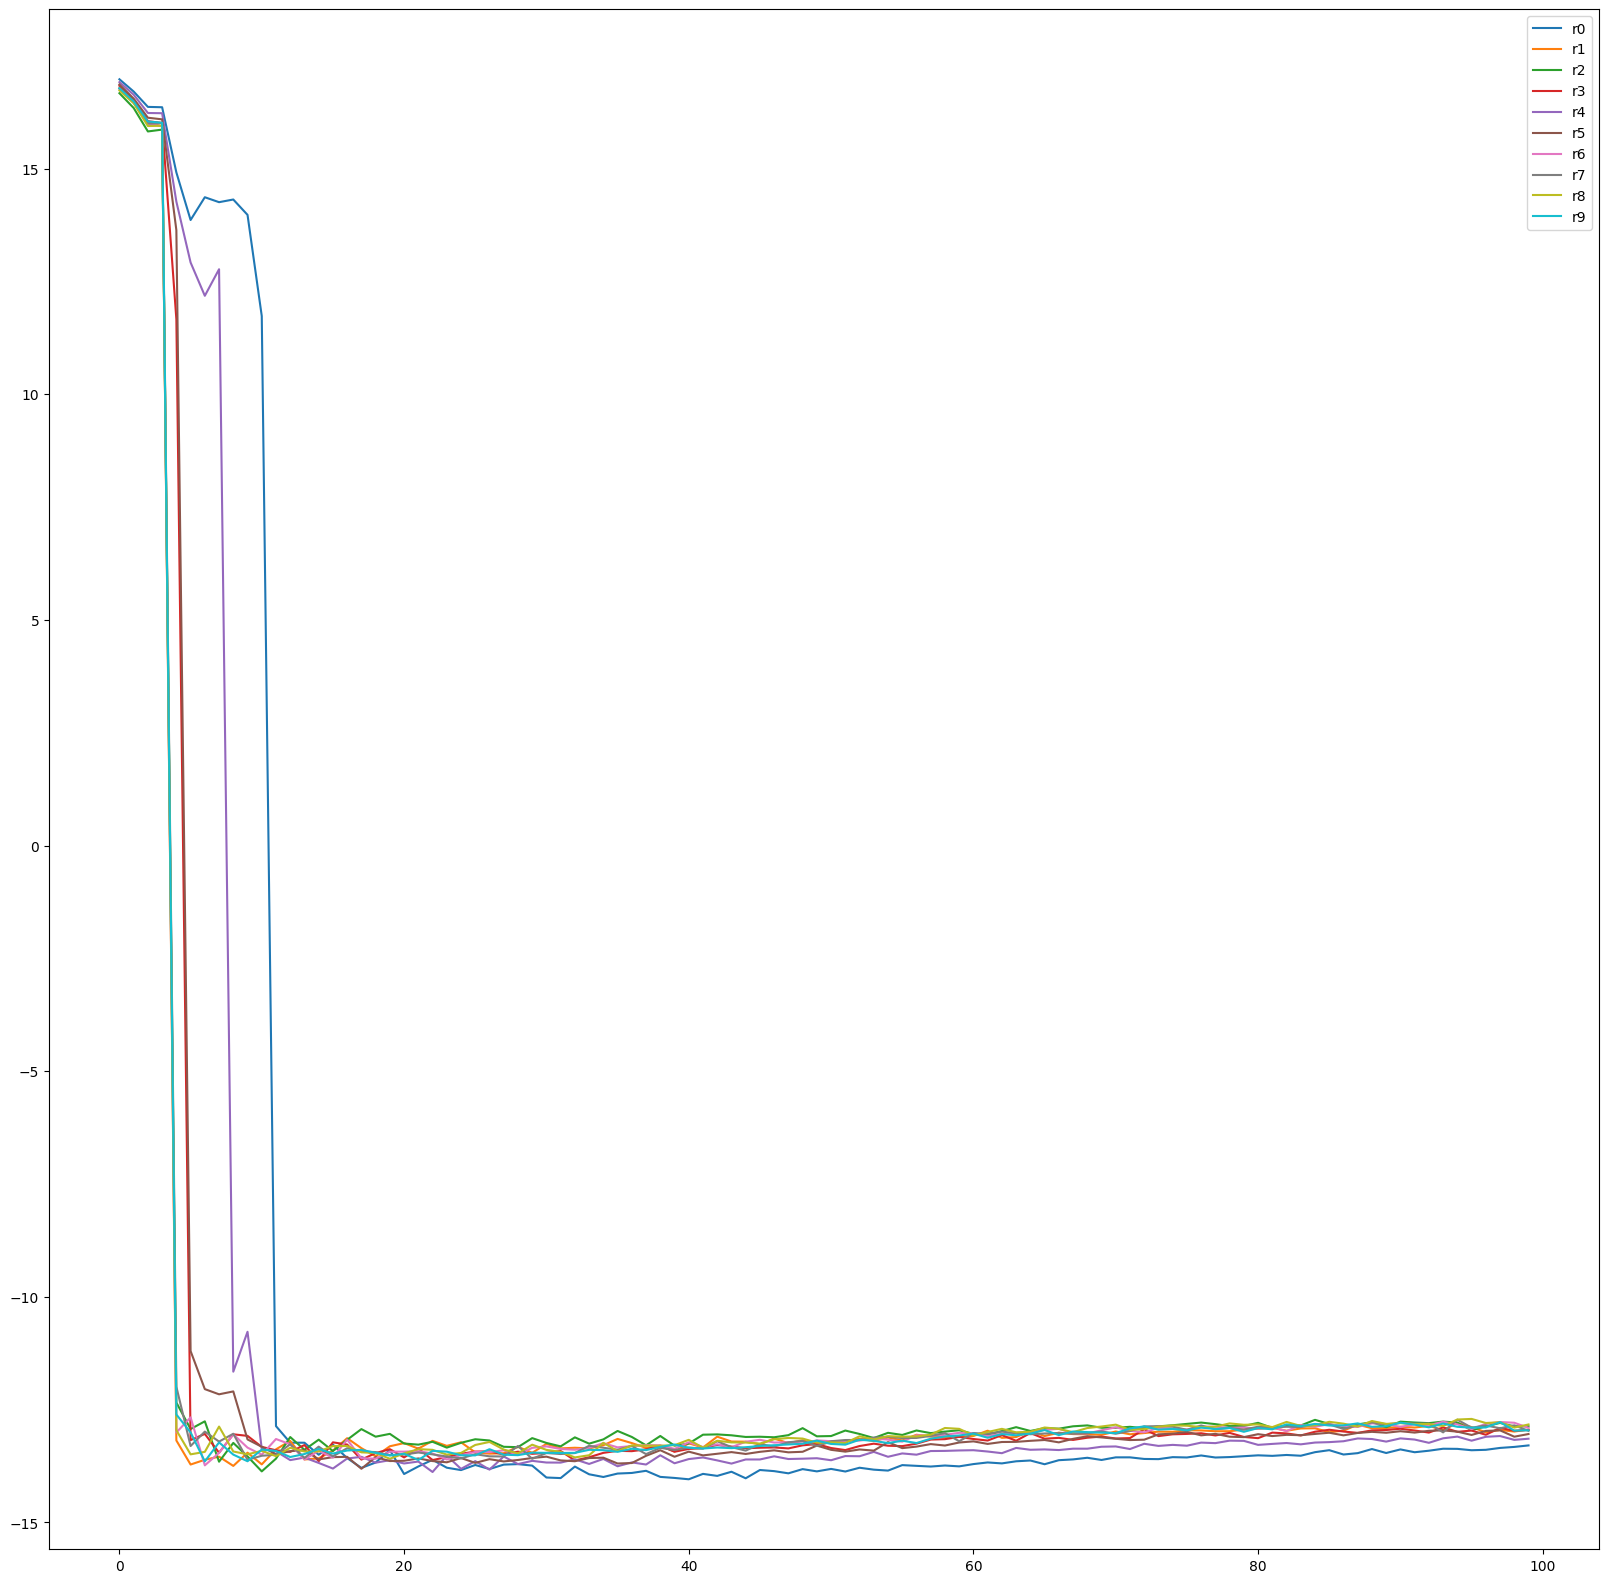

In [138]:
for i,r in enumerate(r_collection):
    plt.plot(r, label = 'r'+str(i))
plt.legend()

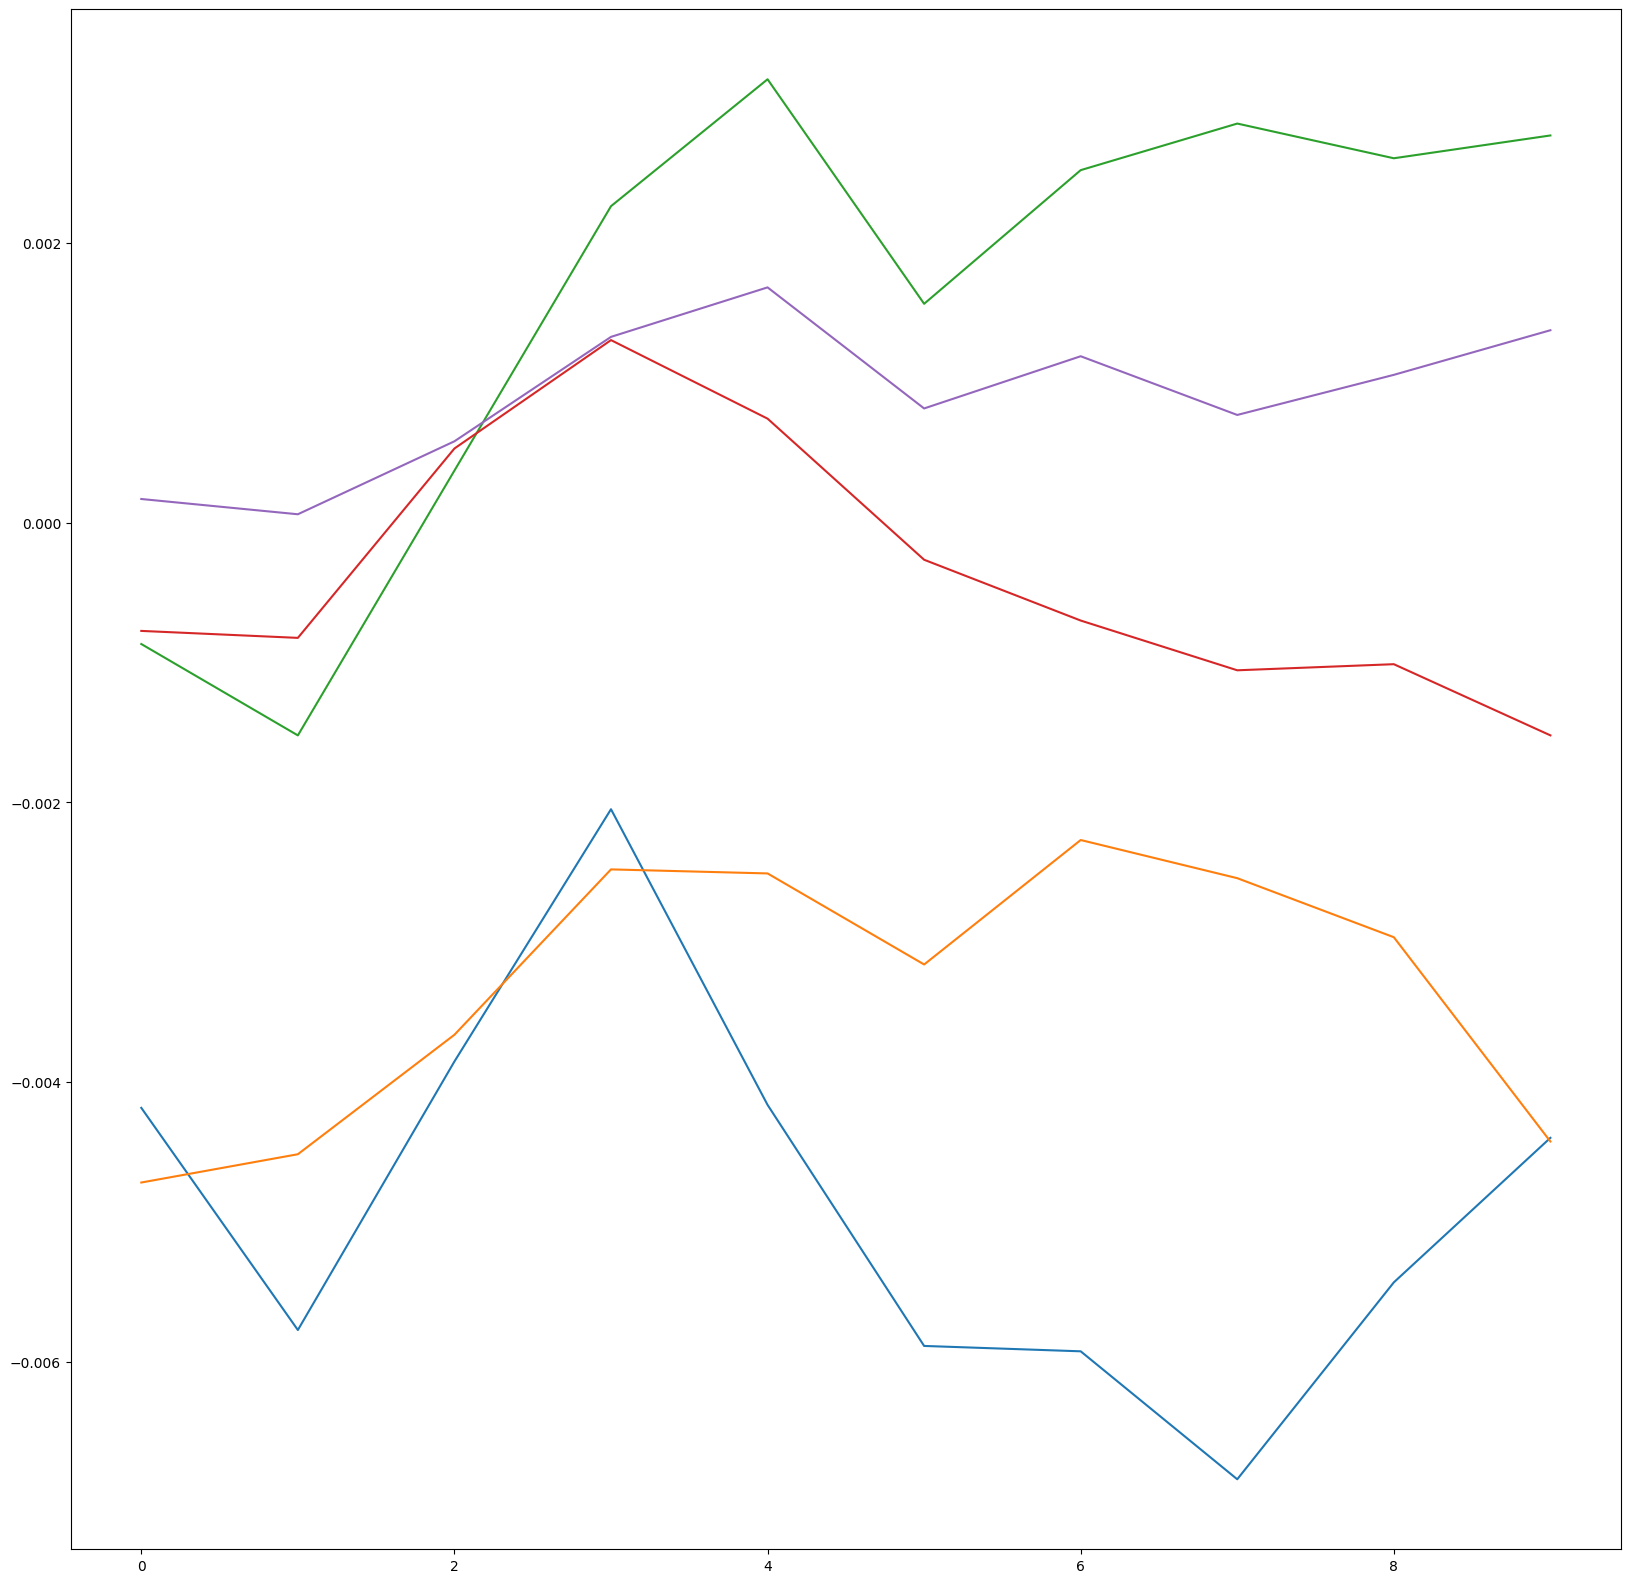

In [139]:
plt.plot(w_collection)

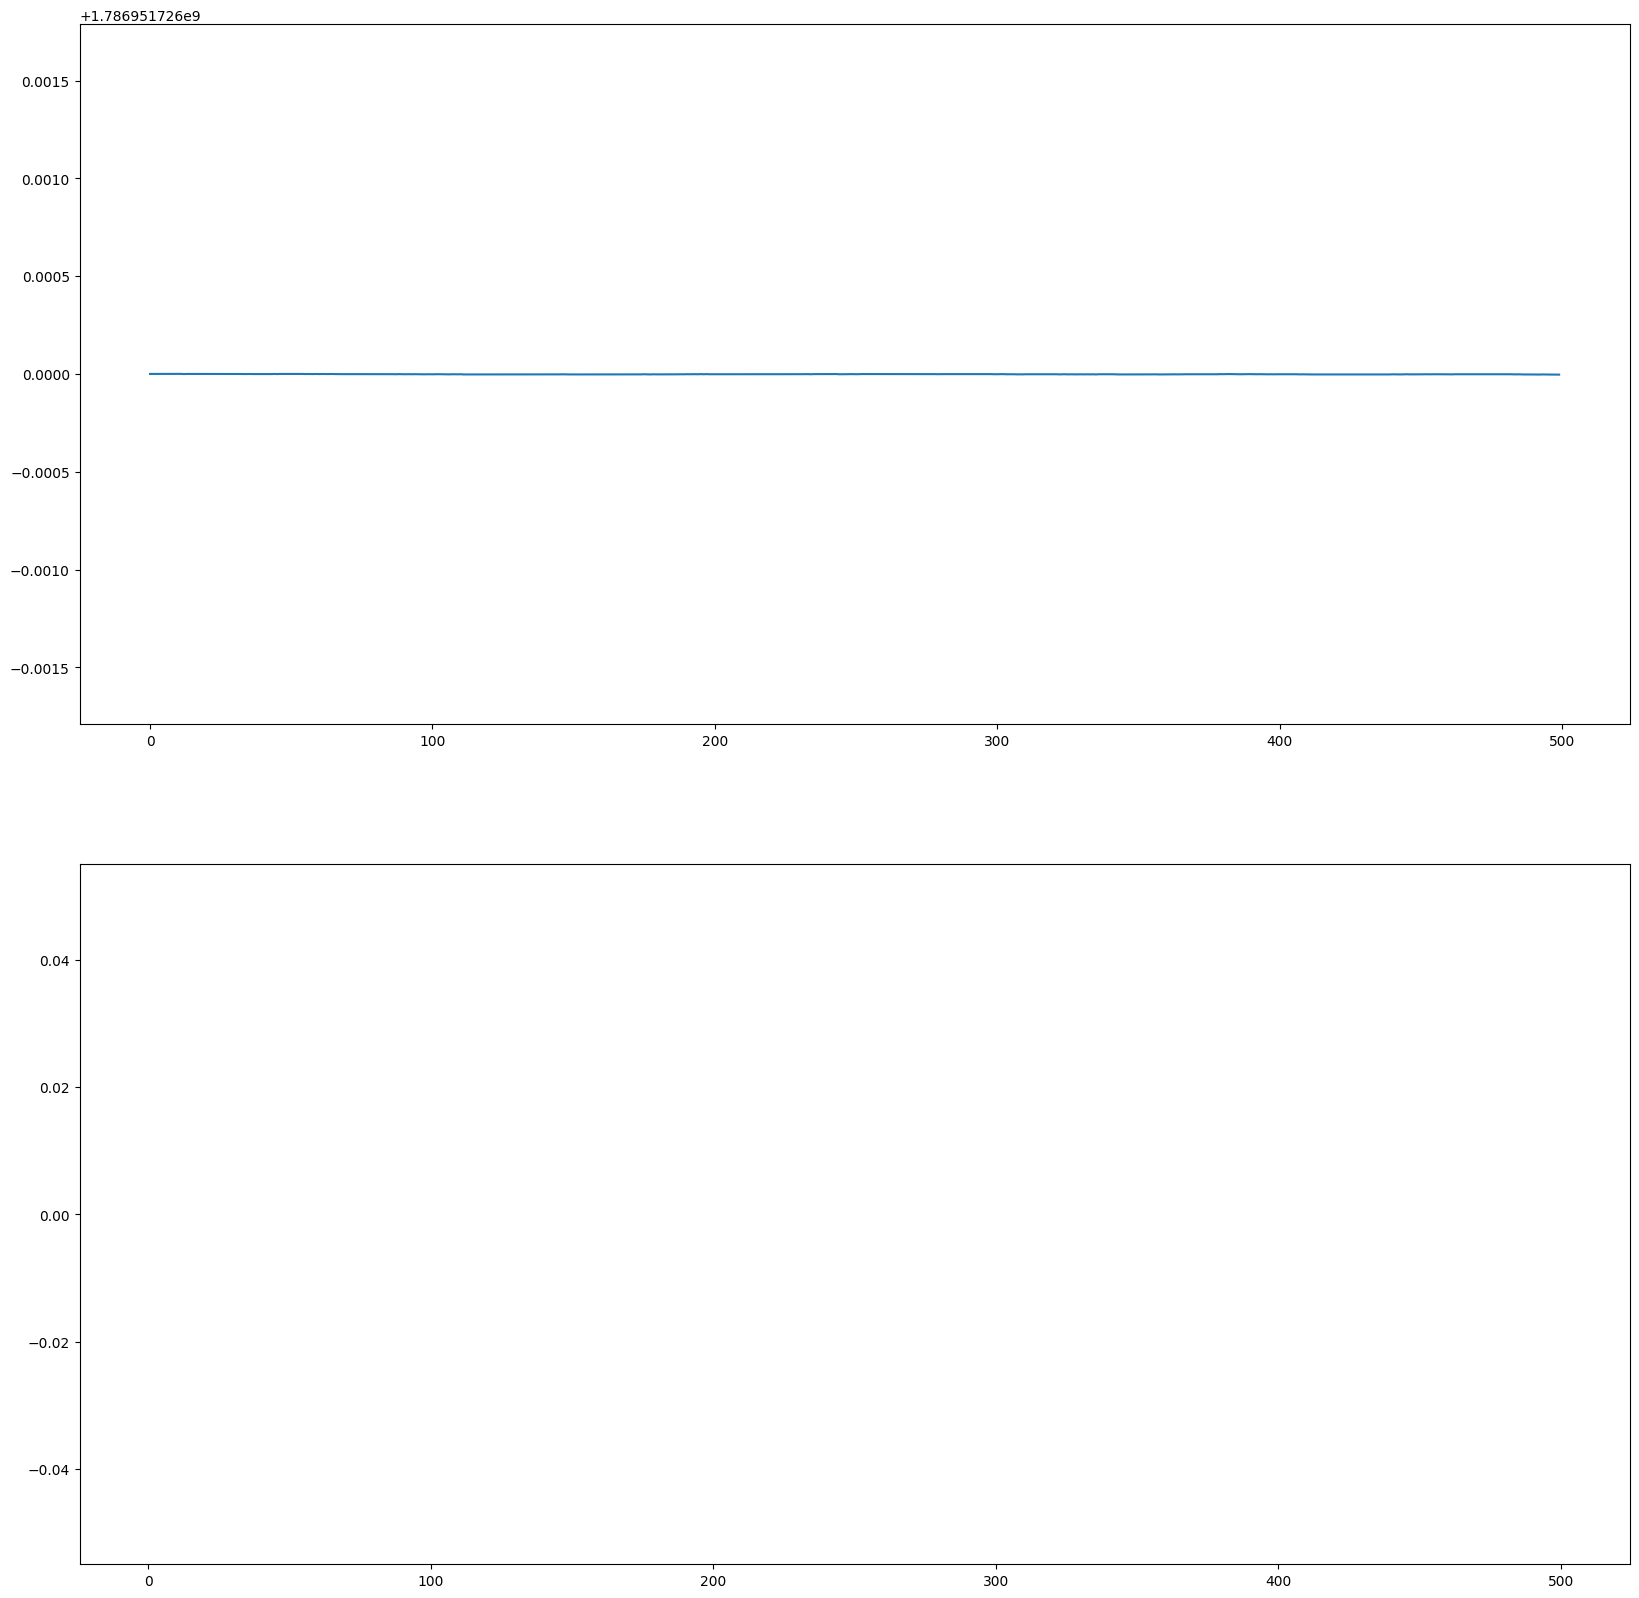

In [135]:
numberOfDefault = [agent_data.xs(i, level="Step")["Default"].sum() for i in range(simulationSteps)]
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(simulationSteps), [agent_data.xs(i, level="Step")["PortfolioValue"].sum() for i in range(simulationSteps)])
ax2.bar(range(1, simulationSteps), np.diff(numberOfDefault))
plt.show()

In [ ]:
np.save()